# * ATM CAMERA*
<i>Author : Vinitha Palani</i><br>
<i>Date   : June 23, 2017<i><br>

## Table of contents <a id='Table-of-contents'></a>

1. [Problem Definition](#Problem)

2. [Required libraries](#Required-libraries)

3. [Load data](#Load-data)

4. [Checking the data](#Checking-the-data)

5. [Dimentionality Reduction](#cleanup)
    
6. [Classification and Cross-validation](#Classify)
    
7. [Finalize the model](#pickle)

8. [If I had more time..](#time)

9. [Acknowledgements](#Acknowledgement)



<a id='Problem'></a>

# Problem Definition

[[ go back to the top ]](#Table-of-contents)

The task is to make a smart ATM camera which can distinguish between dollar notes and checks. We want to make sure that dollars are not classified as checks, and that checks are not classified as dollars.<br>
I was lucky to find a dataset of images of checks and dollars saved as numpy arrays (.npy extension) but I could have built one myself by grabbing a set of images of checks and dollars from Google/Bing image API.These images need to be put into a format suitable for analysis.We need to normalize the images so they're in the same shape.<br>
Each image has been scaled to 322 X 137 pixels, and where each pixel has 3 color channels.The images are then "flattened" and saved as Numpy 2D arrays and are stored as .npy files.

<a id='#Required-libraries'></a>

# Required Libraries

[[ go back to the top ]](#Table-of-contents)

In [2]:
# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import matplotlib.pyplot as plt
#print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import seaborn as sns
print('seaborn: {}'.format(sns.__version__))
%matplotlib inline

Python: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
scipy: 0.18.1
numpy: 1.11.3
pandas: 0.18.1
sklearn: 0.18.1
seaborn: 0.7.1


<a id='#Load-data'></a>

# Load data

[[ go back to the top ]](#Table-of-contents)

The dataset consists of 87 images of checks and dollars, each of which have been scaled to 322 X 137 pixels, and where each pixel has 3 color channels.

In [3]:
#numpy.load is used to load arrays or pickled objects from .npy, .npz or pickled files.
data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
data.shape, y.shape

((87, 132342), (87,))

322 X 137 X 3 = 132342 

<a id='#Checking-the-data'></a>

# Checking the data

[[ go back to the top ]](#Table-of-contents)

In [5]:
STANDARD_SIZE = (322, 137)#standardized pixels in image.
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray
def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

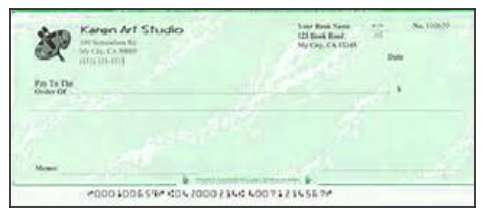

In [6]:
display_image(data[6])

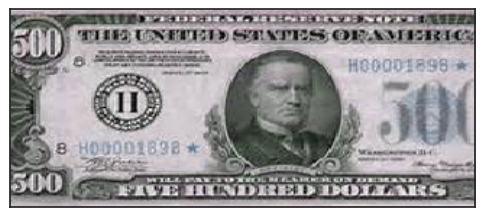

In [8]:
display_image(data[50])

In [14]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([51, 36], dtype=int64))

In [15]:
y[50]

0

In [16]:
y[6]

1

<font color="red">'0' corresponds to dollar.<br>
'1' corresponds to check.</font>

<a id='#cleanup'></a>

# Dimentionality reduction

[[ go back to the top ]](#Table-of-contents)
<br>
The shape of the feature array is (87, 132342). That means there are 132342 features per image !! We better engage in some a-priori feature selection that will reduce the dimensionality of the problem otherwise we are doomed ("Curse of Dimentionality).<br>
<br>
Let's try Principal Component Analysis (PCA)is a technique to reduce the dimensionality of the data, by creating a linear projection. That is, we find new features to represent the data that are a linear combination of the old data (i.e. we rotate it). Thus, we can think of PCA as a projection of our data onto a new feature space.
The way PCA finds these new directions is by looking for the directions of maximum variance. Usually only few components that explain most of the variance in the data are kept. Here, the premise is to reduce the size (dimensionality) of a dataset while capturing most of its information. It can reduce the computational cost when running learning algorithms, decrease the storage space, and may help with the "Curse of dimensionality" <br>
For measuring the generalization error, you need to have a separate PCA for every training set (which would mean doing a separate PCA for every classifier and for every CV fold). You then apply the same transformation to the test set (i.e. you do not do a separate PCA on the test set).<br>
I would like to build an additional PCA model of the whole data set for descriptive (e.g. visualization) purposes.
We choose 60 as a large apriori number: we dont know if the variation in the data will have gone below a reasonable threshold by then.

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [18]:
#The explained variance ratio pca.explained_variance_ratio_ tells us 
#how much of the variation in the features is explained by these 60 features.
print(pca.explained_variance_ratio_.sum())

0.942253550198


When we sum it up over the features, we see that 94% is explained: good enough to go down to a 60 dimensional space from a 136452 dimensional one! <br>
We can see the individual varainces as we increase the dimensionality:

In [19]:
pca.explained_variance_ratio_*100

array([ 35.92596698,   6.29318801,   4.10778347,   3.11950952,
         2.81695972,   2.28831619,   2.10127947,   1.87404973,
         1.7326463 ,   1.53023758,   1.42159654,   1.31839369,
         1.24701477,   1.16381777,   1.09958235,   1.0607274 ,
         1.00742751,   0.98023744,   0.96055732,   0.91535272,
         0.90182836,   0.85213042,   0.83673626,   0.7969168 ,
         0.75487622,   0.72503944,   0.70819876,   0.67963978,
         0.66087587,   0.64735578,   0.62714975,   0.59447957,
         0.58291166,   0.57416911,   0.57259885,   0.55220063,
         0.53832763,   0.53278005,   0.5165271 ,   0.49261426,
         0.48508308,   0.4770215 ,   0.47084271,   0.45088994,
         0.44382585,   0.43979199,   0.43197206,   0.42728305,
         0.41816262,   0.40917699,   0.40319017,   0.39340423,
         0.38809794,   0.38232019,   0.37120188,   0.3580599 ,
         0.35759282,   0.34174472,   0.33667229,   0.32702036])

The first dimension accounts for 35% of the variation, the second 6%, and it goes steadily down from there.
Let us create a dataframe with these 60 features labelled pc1,pc2...,pc60 and the labels of the sample:

In [20]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,label,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,check,1,-22536.362571,-2428.343750,-2133.775569,-328.323675,-1065.243741,79.786583,-424.977193,622.581628,...,-449.556714,200.943351,370.626530,-262.291981,-219.044613,-536.621354,-107.881740,-333.241678,-104.877501,-171.761303
1,check,1,-22226.658684,-709.255511,-288.822972,-1300.637348,-792.094826,217.424522,1076.819129,-2115.000245,...,-583.484548,-85.378668,130.308778,405.438361,268.089151,-567.547200,-99.654634,-267.432302,-290.632279,22.987713
2,check,1,-17364.260784,-4252.027374,793.803846,-1362.057271,-374.241305,3142.083760,2514.230311,1443.784797,...,-2587.891810,-2059.049551,1104.873091,-2129.251625,-1971.506348,-1520.726079,-1564.637559,-496.926888,1390.986158,205.624971
3,check,1,-22847.256200,-900.591882,577.210834,-180.325893,-733.140590,-107.884501,1441.917073,-1069.643124,...,522.262483,-128.543906,-30.171931,-237.908130,-294.027673,491.655406,425.786218,121.180066,-434.018598,-1609.705314
4,check,1,-15868.672595,3259.490907,506.800653,-919.631417,2166.559590,-981.660062,-1669.815465,-391.484538,...,-1390.437169,-2804.550309,19.131567,651.089440,3195.830500,2565.462293,406.192937,-2971.102753,457.471023,1634.970110


In [21]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

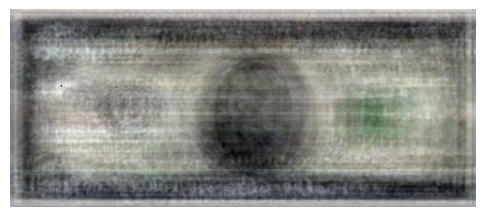

In [22]:
display_component(pca,0)

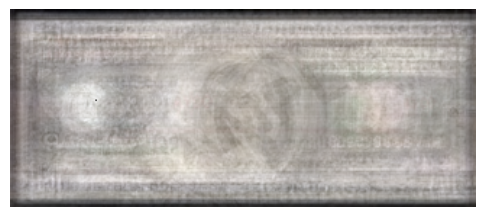

In [23]:
display_component(pca,1)

We take the first two principal components and immediately notice in the diagram below that they are enough to separate out the checks and the dollars. Indeed the first component itself seems to be mostly enough. We can look at the image of the first component and speculate that the medallion in the middle of the dollars probably contributes to this.

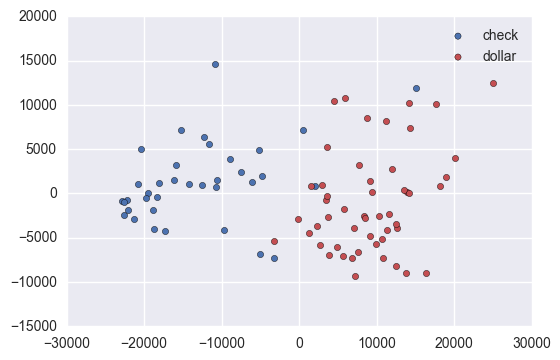

In [25]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

We could thus choose just the first few principal components to make our classifier.<br>
Since two components can be easily visualized (even though adding some more features may leads to better separability), we'll go with learning a 2-dimensional classifier in the pc1 and pc2 dimensions!

<a id='#Classify'></a>

# Classification and Cross-validation

[[ go back to the top ]](#Table-of-contents)
The data seems to be linearly separable (as observed in the scatterplot of the first two principal components). As with many things in life, we follow the Occam's Razor principle and start with simple algoritmns and go for something more complicated only if necessary.<br>
We will try logistic regression first ,followed by KNN and linearSVC then perhaps decision trees or some ensemble method.

In [33]:
#Below is a plot_learning_curve module that's provided by scikit-learn. 
#It allows us to quickly and easily visualize how 
#well the model is performing based on number of samples we're training on. 
#It helps to understand situations such as high variance or bias. 
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,

                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

  

    plt.figure()

    plt.title(title)

    if ylim is not None:

        plt.ylim(*ylim)

    plt.xlabel("Training examples")

    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(

        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)

    test_scores_mean = np.mean(test_scores, axis=1)

    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()



    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,

                     train_scores_mean + train_scores_std, alpha=0.1,

                     color="r")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,

                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",

             label="Training score")

    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",

             label="Cross-validation score")



    plt.legend(loc="best")

    return plt

In [51]:
#KNN (with gridsearch to find optimum parameters)
#Here we use pipeline to avoid contamination of the test set ,we need to do the transformations, 
#namely, Scaling and PCA for the training set of every CV fold and then apply the 
#same transformation to the test set.
#IF we were to do the transformations on the entire Xtrain this could lead to 
#too optimistic estimates of generalization performance, or badly selected parameters
#According to https://stackoverflow.com/questions/21331160/sklearn-principal-component-analysis-leads-to-horrible-results-in-knn-predicti
#there is no need to scale the PCA transformed data.It's possible to pass the whiten=True param to 
#the PCA constructor to get the same result. I did not test this though.
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
kfolds = StratifiedKFold(5)

Xtrain, Xtest, ytrain, ytest = train_test_split(data, y, train_size=0.6)
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), KNeighborsClassifier())
params = {"kneighborsclassifier__n_neighbors": range(1,10,2)}
grid = GridSearchCV(pipeline, param_grid=params, cv=kfolds.split(Xtrain,ytrain))
grid.fit(Xtrain, ytrain)
print(grid.best_params_)
training_accuracy = grid.score(Xtrain, ytrain)
test_accuracy = grid.score(Xtest, ytest)
print("kNN ," + str(grid.best_params_)) 
print("Accuracy on training data: %0.2f" %training_accuracy)
print("Accuracy on test data:     %0.2f" %test_accuracy)

C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted 

{'kneighborsclassifier__n_neighbors': 3}
kNN ,{'kneighborsclassifier__n_neighbors': 3}
Accuracy on training data: 0.96
Accuracy on test data:     0.91


In [52]:
#Logistic Regression 
from sklearn.linear_model import LogisticRegression
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
params = {'logisticregression__C': [.1, 1, 10, 100]}
grid = GridSearchCV(pipeline, param_grid=params, cv=kfolds.split(Xtrain,ytrain))
grid.fit(Xtrain, ytrain)
print(grid.best_params_)
training_accuracy = grid.score(Xtrain, ytrain)
test_accuracy = grid.score(Xtest, ytest)
print("Logistic Regression ," + str(grid.best_params_)) 
print("Accuracy on training data: %0.2f" %training_accuracy)
print("Accuracy on test data:     %0.2f" %test_accuracy)

C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted 

{'logisticregression__C': 1}
Logistic Regression ,{'logisticregression__C': 1}
Accuracy on training data: 0.96
Accuracy on test data:     0.91


C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted 

<module 'matplotlib.pyplot' from 'C:\\Users\\Vini\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

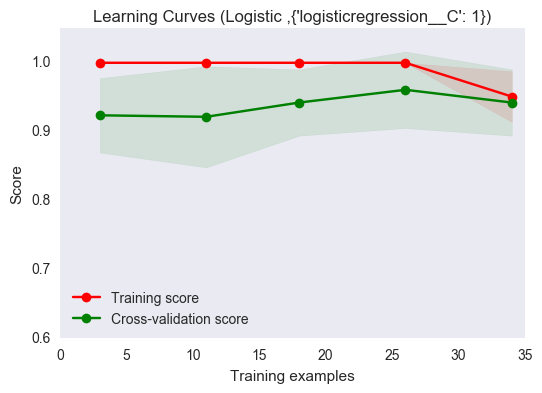

In [53]:
from sklearn.model_selection import learning_curve
title = 'Learning Curves (Logistic ,' + str(grid.best_params_) + ')'  
plot_learning_curve(grid.best_estimator_, title, Xtrain, ytrain, ylim=(0.6, 1.05))

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.We will probably have to use an estimator or a parametrization of the current estimator that can learn more complex concepts (i.e. has a lower bias).

In [55]:
#Linear SVC
from sklearn.svm import SVC
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), SVC(kernel='linear'))
params = param_grid = {'svc__C': [1, 10, 100, 1000]}
grid = GridSearchCV(pipeline, param_grid=params, cv=kfolds.split(Xtrain,ytrain))
grid.fit(Xtrain, ytrain)
print(grid.best_params_)
training_accuracy = grid.score(Xtrain, ytrain)
test_accuracy = grid.score(Xtest, ytest)
print("Linear SVC ," + str(grid.best_params_)) 
print("Accuracy on training data: %0.2f" %training_accuracy)
print("Accuracy on test data:     %0.2f" %test_accuracy)

C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted 

{'svc__C': 1}
Linear SVC ,{'svc__C': 1}
Accuracy on training data: 0.96
Accuracy on test data:     0.91


C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted 

<module 'matplotlib.pyplot' from 'C:\\Users\\Vini\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

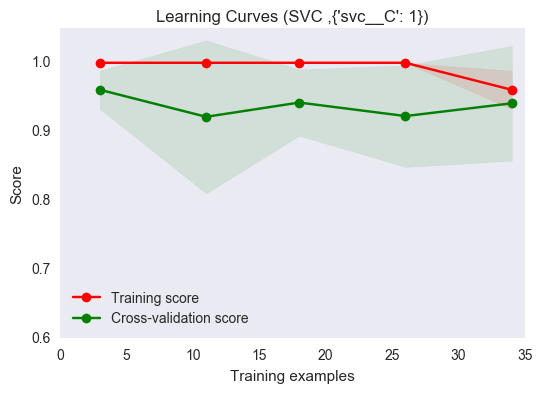

In [56]:
title = 'Learning Curves (SVC ,' + str(grid.best_params_) + ')'  
plot_learning_curve(grid.best_estimator_, title, Xtrain, ytrain, ylim=(0.6, 1.05))

In [58]:
#Trying Decision Tree
from sklearn.tree import DecisionTreeClassifier
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), DecisionTreeClassifier())
pipeline.fit(Xtrain, ytrain)
training_accuracy = pipeline.score(Xtrain, ytrain)
test_accuracy = pipeline.score(Xtest, ytest)
print("Decision Tree") 
print("Accuracy on training data: %0.2f" %training_accuracy)
print("Accuracy on test data:     %0.2f" %test_accuracy)

C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Decision Tree
Accuracy on training data: 1.00
Accuracy on test data:     0.86


Overfitted!!

In [59]:
#Trying Random Forest
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), RandomForestClassifier())
pipeline.fit(Xtrain, ytrain)
training_accuracy = pipeline.score(Xtrain, ytrain)
test_accuracy = pipeline.score(Xtest, ytest)
print("Random Forest") 
print("Accuracy on training data: %0.2f" %training_accuracy)
print("Accuracy on test data:     %0.2f" %test_accuracy)

C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Random Forest
Accuracy on training data: 1.00
Accuracy on test data:     0.91


C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Vini\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted 

<module 'matplotlib.pyplot' from 'C:\\Users\\Vini\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

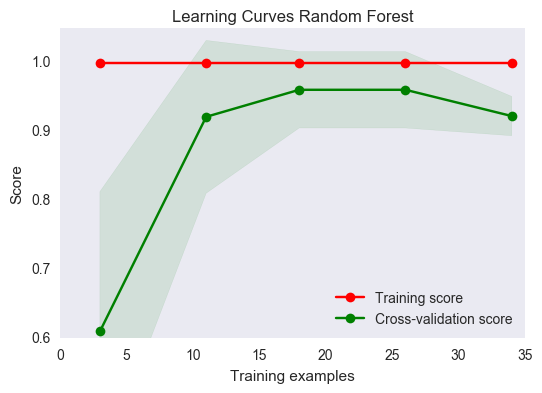

In [60]:
title = 'Learning Curves Random Forest'  
plot_learning_curve(pipeline, title, Xtrain, ytrain, ylim=(0.6, 1.05))

If the training score is much greater than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization.

<a id='#pickle'></a>

# Finalize the model

[[ go back to the top ]](#Table-of-contents)
Though I could do a lot better with more data, I am doing to call it a day (or is it night).
Logistic regression with regularization parameter C = 1 seems to be a decent model with 91% accuracy.
Pickle is the standard way of serializing objects in Python.
You can use the pickle operation to serialize your machine learning algorithms and save the serialized format to a file  

In [63]:
import pickle
test_size = 0.33
seed = 7 
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=test_size, random_state=seed)
#Fit the model on 33%
#C : Inverse of regularization strength; smaller values specify stronger regularization.Default is 1 so no need to set explictly
model = LogisticRegression()
model.fit(X_train, Y_train)
#save the model to disk
filename = 'ATM_camera_final_model.sav'
pickle.dump(model, open(filename, 'wb'))
#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.931034482759


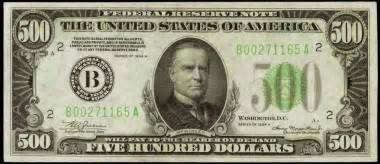

In [68]:
# Let's see how well the model is doing on new data.Testing with these new images 
from IPython.display import Image
Image(filename='dollar.jpg')

In [187]:
#PIL - Python Imaging Library
from PIL import Image
def img_to_matrix(filename, verbose=False):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = Image.open(filename)
    if verbose==True:
        print("changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = np.array(img)
    return img
def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [176]:
data = []
images = ['dollar.jpg']
for image in images:
    img = img_to_matrix(image)
    img = flatten_image(img)
    data.append(img)

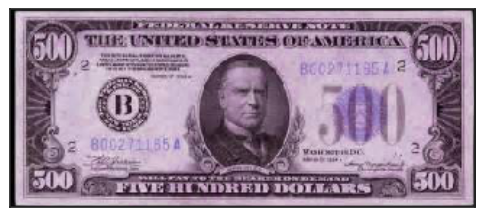

In [146]:
# resized image
display_image(data[0])

In [178]:
data

[array([ 0,  0, 11, ...,  1,  0,  0])]

In [179]:
filename = 'ATM_camera_final_model.sav'
#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result_new = loaded_model.predict(data)

In [184]:
print("I see a",(np.where(result_new==1, "check", "dollar"))[0])

I see a dollar


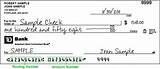

In [185]:
# Let's see if it is able to identify checks.
from IPython.display import Image
Image(filename='check.jpg')

In [188]:
data = []
images = ['check.jpg']
for image in images:
    img = img_to_matrix(image)
    img = flatten_image(img)
    data.append(img)

In [189]:
print("I see a",(np.where((loaded_model.predict(data))==1, "check", "dollar"))[0])

I see a check


Neat! So far so good.

<a id='#time'></a>

# If I had more time ....

[[ go back to the top ]](#Table-of-contents)

If I were to spend more time on this project improving the accuracy a lil more , I would collect more data.

<a id='#Acknowledgement'></a>

# Acknowledgements

[[ go back to the top ]](#Table-of-contents)
<br>
<br>
https://github.com/cs109/2015lab5/blob/master/Classification.ipynb<br>
http://blog.yhat.com/posts/image-classification-in-Python.html<br>
https://github.com/amueller/scipy-2016-sklearn/blob/master/notebooks/07%20Unsupervised%20Learning%20-%20Transformations%20and%20Dimensionality%20Reduction.ipynb<br>

